# Setup

In [2]:
import time
import pandas as pd
import numpy as np
from scipy.interpolate import interpn
from scipy import ndimage as ndi
import cv2
from os import listdir
from random import sample, uniform

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

from skimage.morphology import watershed
from skimage import morphology, color, segmentation, data, filters, draw
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.feature import canny
from skimage.exposure import histogram

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.utils.data import get_pkg_data_filename
from spectral_cube import SpectralCube, BooleanArrayMask
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Gaussian1DKernel
from astropy.utils.data import download_file
from astropy import units as u
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy import wcs

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import register_cmap, cmap_d
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

%matplotlib inline

In [3]:
# Get ds9 map
ds9aips0 = {'red': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.475, 0, 0.373, 0, 0, 1, 1, 1]), 
            'green': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0, 0, 0.655, 0.596, 0.965, 1, 0.694, 0]),
            'blue': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.608, 0.785, 0.925, 0, 0, 0, 0, 0])}
register_cmap('ds9aips0', data=ds9aips0)

In [4]:
def plot_cube(cube, wcs, slice_i=10, sliced=True):
    fig = plt.figure()
    if sliced:
        ax = fig.add_subplot(projection=wcs, slices=('y', 'x', slice_i))
    else:
        ax = fig.add_subplot(projection=wcs)
    norm = ImageNormalize(cube[slice_i, :, :], interval=ZScaleInterval())
    im = ax.imshow(cube[slice_i, :, :], origin='lower', cmap='ds9aips0', norm=norm)
    cbar = plt.colorbar(im)
    cbar.set_label('Frequency (Hz)', size=16)
    plt.xlabel('Right Ascension (J2000)', fontsize=16)
    plt.ylabel('Declination (J2000)', fontsize=16)
    plt.show()

In [5]:
def load_gal(filename):
    gal_data = fits.open(filename)
    gal_cube_data = gal_data[0].data
    gal_data[0].header['CTYPE3'] = 'FREQ'
    gal_wcs = WCS(gal_data[0].header)
    gal_data.close() 
    return gal_wcs, gal_cube_data, gal_data[0].header

def scale_gal(gal_cube_data, dim=(512, 512)):
    img_stack_sm = np.zeros((gal_cube_data.shape[0], dim[0], dim[1]))
    for idx in range(len(gal_cube_data)):
        img_stack_sm[idx, :, :] = cv2.resize(gal_cube_data[idx, :, :], dim, interpolation=cv2.INTER_CUBIC)
    return img_stack_sm

def smooth_gal(img_stack_sm, header):
    # Subcube (need to make this dependent on galaxy size)
#     gal_subcube = gal_cube_data[90:110, 150:250, 150:250]
    ts = (15*u.arcsecond).to('deg').value
    # Smooth using Gaussian with sigma = tel_res/pixel_size in each direction
    sigma1, sigma2, sigma3 = ts/header['CDELT1'], ts/header['CDELT2'], ts/header['CDELT3']
    convolved_image = ndi.gaussian_filter(img_stack_sm, sigma=(sigma1, sigma2, sigma3), order=0)
    return convolved_image

def crop_gal(convolved_image, scale=1):
    # Crop around galaxy
    true_points = np.argwhere(convolved_image > np.mean(convolved_image))
    c1 = true_points.min(axis=0)
    c2 = true_points.max(axis=0)
    cropped = convolved_image[:, c1[1]:c2[1]+1,
              c1[2]:c2[2]+1]
    return cropped*scale

def insert_gal(cropped, subcube, empty_cube):
    # Randomly place galaxy in x and y direction and fill whole z
    mk, mi, mj = cropped.shape
    si = int(uniform(0, subcube.shape[1]-mi))
    sj = int(uniform(0, subcube.shape[2]-mj))
    sk = int(uniform(0, subcube.shape[0]-mk))
    in_loc = subcube[sk:sk+mk, si:si+mi, sj:sj+mj]
    subcube[sk:sk+mk, si:si+mi, sj:sj+mj] = cropped + in_loc
    empt_loc = empty_cube[sk:sk+mk, si:si+mi, sj:sj+mj]
    empty_cube[sk:sk+mk, si:si+mi, sj:sj+mj] = cropped + empt_loc
    return subcube

## Import and Visualise Data

## Smooth and insert artifical galaxies

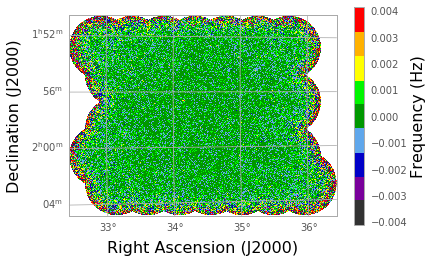

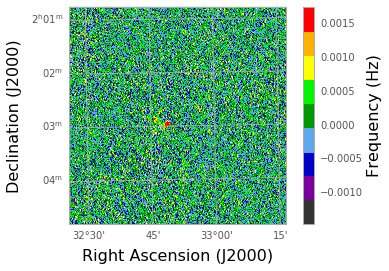

In [6]:
hi_data = fits.open('data/1245mosC.derip.fits')
cube_data = hi_data[0].data
wcs = WCS(hi_data[0].header)
hi_data.close()
plot_cube(cube_data, wcs, slice_i=471, sliced=True)
subcube = cube_data[:, 800:1312, 800:1312]
plot_cube(subcube, wcs, slice_i=471, sliced=True)
dim = subcube.shape[1:]
empty_cube = np.zeros(subcube.shape)

In [9]:
# dup_cube = subcube.copy()
empty_cube = np.zeros(subcube.shape)
dim = subcube.shape[1:]
for filename in listdir('data/mock_gals'):
    gal_wcs, gal_cube_data, header = load_gal('data/mock_gals/' + filename)
    # Subcube (need to make this dependent on galaxy size)
    # gal_subcube = gal_cube_data[90:110, 150:250, 150:250]
    img_stack_sm = scale_gal(gal_cube_data, dim)
    convolved_image = smooth_gal(img_stack_sm, header)
    cropped = crop_gal(convolved_image)
    subcube = insert_gal(cropped, subcube, empty_cube)

Loading...
Rescaling...
Resampling...
Cropping...
Inserting...
Loading...
Rescaling...
Resampling...
Cropping...
Inserting...
Loading...
Rescaling...
Resampling...
Cropping...
Inserting...
Loading...
Rescaling...
Resampling...
Cropping...
Inserting...
Loading...
Rescaling...
Resampling...
Cropping...
Inserting...
Loading...
Rescaling...
Resampling...
Cropping...
Inserting...


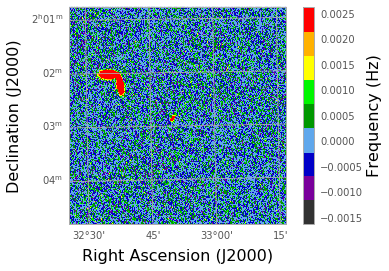

In [19]:
plot_cube(subcube, wcs, slice_i=510, sliced=True)

In [ ]:
print("Loading...")
gal_wcs, gal_cube_data, header = load_gal('data/mock_gals/model1000.fits')
# Subcube (need to make this dependent on galaxy size)
# gal_subcube = gal_cube_data[90:110, 150:250, 150:250]
print("Rescaling...")
img_stack_sm = scale_gal(gal_cube_data, dim)
print("Resampling...")
convolved_image = smooth_gal(img_stack_sm, header)
print("Cropping...")
cropped = crop_gal(convolved_image, scale=1)
print("Inserting...")
subcube = insert_gal(cropped, subcube, empty_cube)

plot_cube(subcube, wcs, slice_i=471, sliced=True)

### Insert randomly in noise cube

In [21]:
noise_data = fits.open('data/U6805.lmap.fits')
noise_cube_data = noise_data[0].data
noise_data[0].header['CTYPE3'] = 'FREQ'
noise_wcs = WCS(key='B1950')
noise_data.close() 

In [ ]:
files = [filename for filename in listdir('data') if "model" in filename]
new_cubes = []
mask_cubes = []
for i in range(10):
    dup_cube = noise_cube_data.copy()
    empty_cube = dup_cube - dup_cube
    for filename in files:
        gal_wcs, convolved_image = get_mock_gal("data/"+filename, conv=False, scale=1e2,
                                                dim=dup_cube.shape[1:])
        new_cube, mask_cube = insert_gal(convolved_image, dup_cube, empty_cube)
    new_cubes.append(new_cube)
    mask_cubes.append(mask_cube)

In [ ]:
cube_i = 5
for i in np.linspace(0, len(new_cubes[cube_i])-1, 11):
    plot_cube(new_cubes[cube_i], noise_wcs, slice_i=int(i), sliced=False)

### Insert randomly in Apertif cube

In [ ]:
subcube = cube_data[452:652, 944:1456, 944:1456]
new_cubes = []
mask_cubes = []
for i in range(10):
    dup_cube = subcube.copy()
    empty_cube = dup_cube - dup_cube
    for filename in files:
        gal_wcs, convolved_image = get_mock_gal("data/"+filename, dim=dup_cube.shape[1:])
        new_cube, mask_cube = insert_gal(convolved_image, dup_cube, empty_cube)
    new_cubes.append(new_cube)
    mask_cubes.append(mask_cube)

In [ ]:
cube_i = 5
for i in np.linspace(0, len(new_cubes[cube_i])-1, 5):
    plot_cube(new_cubes[cube_i], wcs, slice_i=int(i), sliced=True)

# MTObjects

In [ ]:
import higra as hg

def get_tile_images(image, width, height):
    import numpy as np
    _nrows, _ncols = image.shape
    _size = image.size
    _strides = image.strides

    nrows, _m = divmod(_nrows, height)
    ncols, _n = divmod(_ncols, width)
    if _m != 0 or _n != 0:
        image = image[:-_m,:-_n]

    return np.lib.stride_tricks.as_strided(
        np.ravel(image),
        shape=(nrows, ncols, height, width),
        strides=(width * _strides[1], height * _strides[0], *_strides),
        writeable=False
    )

def estimate_background(im, rejection_rate=0.7, tile_size=32, show_tiles=False):
    from scipy.stats import normaltest, ttest_ind
    tile_size_D2 = tile_size // 2
    
    # split image in tiles
    tiles = get_tile_images(im, width=tile_size, height=tile_size)
    tiles = np.reshape(tiles, (-1, tile_size, tile_size))
    ntiles = tiles.shape[0]
    
    # normal distribution test on the whole tiles
    alpha1 = 1 - (1 - rejection_rate) ** 0.5
    _, p_val = normaltest(tiles.reshape((-1, tile_size * tile_size)), axis=1)

    # test if the distribution on the two halves of the tiles are the same
    alpha2 = 1 - (1 - rejection_rate) ** 0.25
    # vertical split
    _, p_val1 = ttest_ind(tiles[:, :tile_size_D2, :].reshape((ntiles, -1)), tiles[:, tile_size_D2:, :].reshape((ntiles, -1)), axis=1)
    # horizontal split
    _, p_val2 = ttest_ind(tiles[:, :, :tile_size_D2].reshape((ntiles, -1)), tiles[:, :, tile_size_D2:].reshape((ntiles, -1)), axis=1)
    
    # a tile is background if it passes the three tests
    ok_tiles = np.logical_and(p_val > alpha1, np.logical_and(p_val1 > alpha2, p_val2 > alpha2))
    tiles = tiles[ok_tiles, ...]

    if len(tiles) == 0:
        raise Exception("Cannot detect background, try decreasing the rejection rate or the tile size.")
        
    if show_tiles:
        print("Tiles selected for background estimation")
        plt.imshow(np.hstack(tiles), cmap="gray")
    
    tiles = np.ravel(tiles)
   
    background_mean = np.mean(tiles)
    background_var = np.var(tiles)
    minimum = np.amin(np.ravel(im))
    gain = (background_mean - minimum) / background_var
    
    return np.mean(tiles), np.var(tiles), gain
    

def attribute_power(tree, altitudes, image):
    # power is computed using the following formula:
    # P(n) = sum_x(image(x)²) - 2*altitude(parent(n))*sum_x(image(x)) + area(n)*altitude(parent(n))²
    area = hg.attribute_area(tree)
    sum_vals = hg.accumulate_sequential(tree, image, hg.Accumulators.sum)
    sum_vals2 = hg.accumulate_sequential(tree, image * image, hg.Accumulators.sum)
    return sum_vals2 + area * altitudes[tree.parents()]**2 - 2 * altitudes[tree.parents()] * sum_vals

def attribute_statistical_significance(tree, altitudes, image, alpha, background_var, gain):
    from scipy.stats import chi2
    
    area = hg.attribute_area(tree)
    power = attribute_power(tree, altitudes, image)
    power /= (background_var + altitudes[tree.parents()] / gain)
   
    significant_nodes = power > chi2.ppf(alpha, area) # inverse cdf
    significant_nodes[:tree.num_leaves()] = False
    return significant_nodes

def attribute_main_branch(tree):
    # True is a node is not the root of a main branch
    area = hg.attribute_area(tree)
    largest_child = hg.accumulate_parallel(tree, area, hg.Accumulators.argmax)
    child_number = hg.attribute_child_number(tree)
    return child_number == largest_child[tree.parents()]

def select_objects(tree, altitudes, significant_nodes):
    filtered_tree, node_map = hg.simplify_tree(tree, np.logical_not(significant_nodes))
    
    main_branch = attribute_main_branch(filtered_tree)

    # special case for the root
    if not significant_nodes[tree.root()]:
        root_children = filtered_tree.children(filtered_tree.root())
        main_branch[root_children] = False
        
    res = np.zeros(tree.num_vertices(), dtype=np.bool)
    res[node_map] = np.logical_not(main_branch)
    return res

def move_up(tree, altitudes, objects, alambda, background_var, gain):
    # true if a node is in the main branch of its parent
    main_branch = attribute_main_branch(tree)
    
    # index of the closest object ancestor in the main branch, itself otherwise
    closest_object_ancestor = hg.propagate_sequential(
        tree, 
        np.arange(tree.num_vertices()), 
        np.logical_and(main_branch, np.logical_not(objects)))
    
    # objects should be move up in the main branch to their target altitude
    target_altitudes = altitudes.copy()
    object_indexes, = np.nonzero(objects)
    local_noise = np.sqrt(background_var + altitudes[tree.parent(object_indexes)] / gain)
    target_altitudes[object_indexes] = altitudes[object_indexes] + alambda * local_noise
    
    # target altitude associated to the closest object anacestor in the main branch, self altitude otherwise
    target_altitudes = target_altitudes[closest_object_ancestor]
    # a move is valid if the target altitude of the closest object ancestor in the main branch is lower than the
    # the curent altitude and if the closest object is a real object
    valid_moves = np.logical_and(altitudes >= target_altitudes, objects[closest_object_ancestor])
    
    parent_closest_object_ancestor = closest_object_ancestor[tree.parents()]
    parent_not_valid_moves = np.logical_not(valid_moves[tree.parents()])
    # a new object is a node n such that (valid_move(n) && (!valid_move(parent(n)) || closest(n) != closest(parent(n))))
    new_objects = np.logical_and(
        valid_moves, 
        np.logical_or(
            parent_not_valid_moves, 
            parent_closest_object_ancestor != closest_object_ancestor))
    return new_objects


In [ ]:
znorm = ZScaleInterval()
# subcube = znorm(new_cubes[2][37, :, :])
source_cube = cube_data[470, 700:1300, 700:1300]
subcube = znorm(source_cube)
background_mean, background_var, gain = estimate_background(subcube, rejection_rate=0.7, show_tiles=True)
print("Mean:", background_mean, "Variance:", background_var, "Gain:", gain)
im_normalized = subcube - background_mean

im_normalized = np.clip(im_normalized, a_min=0, a_max=None)

graph = hg.get_4_adjacency_graph(im_normalized.shape)
tree, altitudes = hg.component_tree_max_tree(graph, im_normalized)


significant_nodes = attribute_statistical_significance(tree, altitudes, im_normalized, 1-1e-6, background_var, gain)
objs = select_objects(tree, altitudes, significant_nodes)

nobjs = move_up(tree, altitudes, objs, 0.1, background_var, gain)     

# construct final segmentation with random colors as labels
colors = np.random.randint(0, 256, (tree.num_vertices(), 3), dtype=np.uint8)
colors[tree.root(),:] = 255
seg = hg.reconstruct_leaf_data(tree, colors, np.logical_not(nobjs))

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(projection=noise_wcs)
im = ax.imshow(subcube, origin='lower', cmap='ds9aips0')
cbar = plt.colorbar(im)
cbar.set_label('Frequency (Hz)', size=16)
plt.xlabel('Right Ascension (J2000)', fontsize=16)
plt.ylabel('Declination (J2000)', fontsize=16)
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(seg, origin='lower')
plt.xlabel('Right Ascension (J2000)', fontsize=16)
plt.ylabel('Declination (J2000)', fontsize=16)
plt.show()

# Traditional Methods

## Thresholding

In [ ]:
masked = source_slice > np.mean(source_slice) + 3*np.std(source_slice)
plot_slice(source_slice, hi_data, mask=masked)

## Region-based segmentation


In [ ]:
elevation_map = filters.sobel(source_slice)
markers = np.zeros_like(source_slice)
markers[source_slice < 0.001] = 1
markers[source_slice > 0.002] = 2
segmentated = segmentation.watershed(elevation_map, markers)
segmentated = ndi.binary_fill_holes(segmentated - 1)
plot_slice(source_slice, hi_data, segmentated)

## Edge-based segmentation

In [ ]:
edges = canny(source_slice)
fill = ndi.binary_fill_holes(edges)
cleaned = morphology.remove_small_objects(fill, 10)
plot_slice(source_slice, hi_data, mask=cleaned)

# Unspervised Segmentation

## K Means Clustering

In [ ]:
# kmeans = KMeans(n_clusters=3, random_state=0).fit(source_slice)
# cluster_pic = kmeans.cluster_centers_[kmeans.labels_]
# plot_slice(source_slice, hi_data, cluster_pic)

## Supervised Learning

## Random Forests